In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping  
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

DATASET_DIR = r"C:\Users\gfxsc\Desktop\Deep learning Datasets\fungal_classification"

IMG_SIZE = (224, 224)   
BATCH_SIZE = 32
EPOCHS_HEAD = 12     
EPOCHS_FT   = 28      
TOTAL_EPOCHS = EPOCHS_HEAD + EPOCHS_FT

BASE_LR_HEAD = 1e-3  
BASE_LR_FT   = 1e-5  

L2_WEIGHT = 1e-4       
DROPOUT   = 0.4   
LABEL_SMOOTH = 0.1    
PATIENCE_LR  = 3       

In [4]:
import os
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(DATASET_DIR, 'train')
valid_dir = os.path.join(DATASET_DIR, 'valid')
test_dir  = os.path.join(DATASET_DIR, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
print("Classes:", train_generator.class_indices)

from collections import Counter
counts = Counter(train_generator.classes)
max_count = max(counts.values())
CLASS_WEIGHTS = {cls: max_count / cnt for cls, cnt in counts.items()}
print("Class weights (optional):", CLASS_WEIGHTS)


Found 5000 images belonging to 5 classes.
Found 899 images belonging to 5 classes.
Found 902 images belonging to 5 classes.
Classes: {'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}
Class weights (optional): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


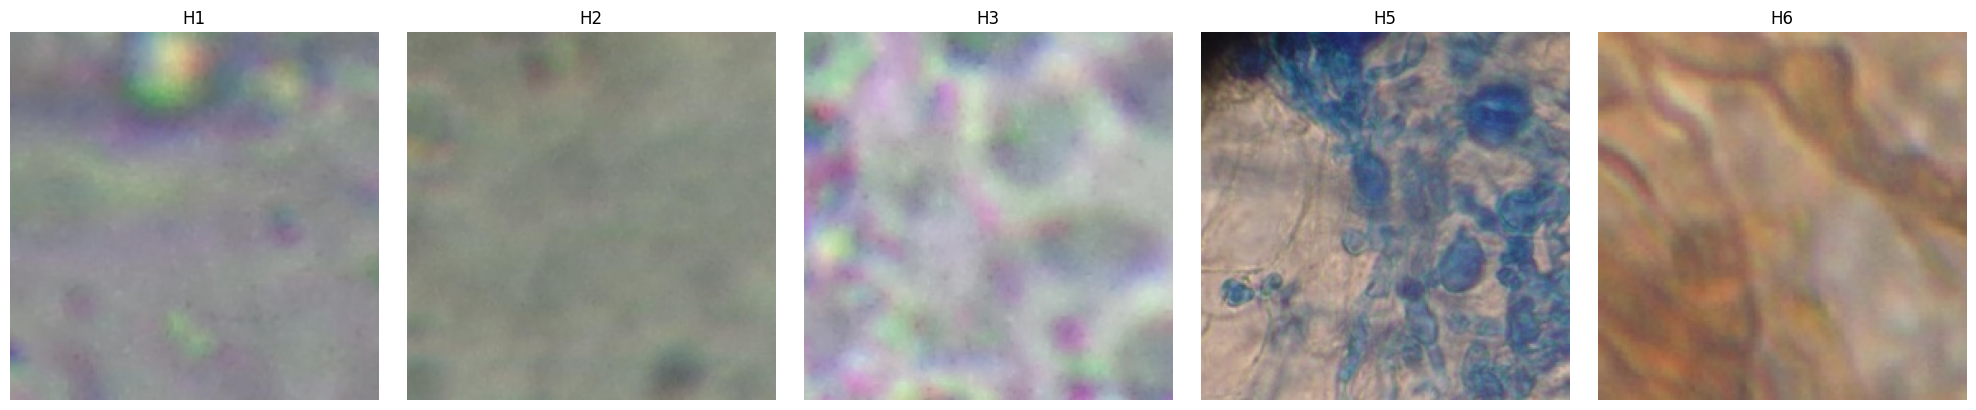

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def show_sample_images(generator):
    """
    Show ONE image per class from the generator.
    Robust to class imbalance and shuffling.
    """
    idx_to_class = {v: k for k, v in generator.class_indices.items()}
    n_classes = len(idx_to_class)

    fig, axes = plt.subplots(1, n_classes, figsize=(4*n_classes, 4))
    if n_classes == 1:
        axes = [axes]

    found = {i: False for i in range(n_classes)}
    filled = 0

    generator.reset()

    steps = len(generator)
    for _ in range(steps):
        images, labels = next(generator)
        y = np.argmax(labels, axis=1)

        for img, cls_idx in zip(images, y):
            if not found[cls_idx]:
                ax = axes[cls_idx]
                ax.imshow(img)
                ax.set_title(idx_to_class[cls_idx])
                ax.axis('off')
                found[cls_idx] = True
                filled += 1
                if filled == n_classes:
                    break
        if filled == n_classes:
            break

    for i in range(n_classes):
        if not found[i]:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(train_generator)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG19

NUM_CLASSES = train_generator.num_classes

BASE_LR_HEAD = 1e-3      
BASE_LR_FT   = 1e-5     
L2_WEIGHT    = 1e-4
DROPOUT      = 0.4
LABEL_SMOOTH = 0.1

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

base_model = VGG19(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(
    512, activation='relu',
    kernel_regularizer=regularizers.l2(L2_WEIGHT)
)(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(
    NUM_CLASSES, activation='softmax',
    kernel_regularizer=regularizers.l2(L2_WEIGHT)
)(x)

model = models.Model(inputs, outputs)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)

model.compile(
    optimizer=tf.keras.optimizers.Adam(BASE_LR_HEAD),
    loss=loss,
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289,605 (77.40 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                              min_lr=1e-7, verbose=1)

ckpt = ModelCheckpoint('best_head_then_ft.keras',
                       monitor='val_accuracy', mode='max',
                       save_best_only=True, verbose=1)

log = CSVLogger('training_log.csv', append=True)

EPOCHS_HEAD = 12 

history_head = model.fit(
    train_generator,
    epochs=EPOCHS_HEAD,
    validation_data=valid_generator,
    callbacks=[reduce_lr, ckpt, log],
    class_weight=CLASS_WEIGHTS if 'CLASS_WEIGHTS' in globals() and CLASS_WEIGHTS else None
)


c:\Users\gfxsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2900 - loss: 1.6682
Epoch 1: val_accuracy improved from None to 0.50278, saving model to best_head_then_ft.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.3506 - loss: 1.5606 - val_accuracy: 0.5028 - val_loss: 1.4433 - learning_rate: 0.0010
Epoch 2/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4215 - loss: 1.4571
Epoch 2: val_accuracy did not improve from 0.50278
157/157 ━━━━━━━━━━━━━━━━━━━━ 588s 4s/step - accuracy: 0.4318 - loss: 1.4443 - val_accuracy: 0.4950 - val_loss: 1.4591 - learning_rate: 0.0010
Epoch 3/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4303 - loss: 1.4218
Epoch 3: val_accuracy improved from 0.50278 to 0.54283, saving model to best_head_then_ft.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 556s 4s/step - accuracy: 0.4406 - loss: 1.4155 - val_accuracy: 0.5428 - val_loss: 1.3345 - learning_rate: 0.0010
Epoch 4/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4287 - loss: 1

In [9]:
for layer in base_model.layers:
    layer.trainable = layer.name.startswith('block5')

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=loss,
              metrics=['accuracy'])

TOTAL_EPOCHS = 40 
history_ft = model.fit(
    train_generator,
    initial_epoch=EPOCHS_HEAD,
    epochs=TOTAL_EPOCHS,
    validation_data=valid_generator,
    callbacks=[reduce_lr, ckpt, log],
    class_weight=CLASS_WEIGHTS if 'CLASS_WEIGHTS' in globals() and CLASS_WEIGHTS else None
)

model.load_weights('best_head_then_ft.keras')


Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5001 - loss: 1.3195
Epoch 13: val_accuracy did not improve from 0.54283
157/157 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.5200 - loss: 1.2884 - val_accuracy: 0.4561 - val_loss: 1.3597 - learning_rate: 1.0000e-05
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5450 - loss: 1.2446
Epoch 14: val_accuracy improved from 0.54283 to 0.55061, saving model to best_head_then_ft.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 608s 4s/step - accuracy: 0.5644 - loss: 1.2210 - val_accuracy: 0.5506 - val_loss: 1.2468 - learning_rate: 1.0000e-05
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5737 - loss: 1.1970
Epoch 15: val_accuracy did not improve from 0.55061
157/157 ━━━━━━━━━━━━━━━━━━━━ 612s 4s/step - accuracy: 0.5924 - loss: 1.1784 - val_accuracy: 0.5028 - val_loss: 1.3020 - learning_rate: 1.0000e-05
Epoch 16/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6062 - loss: 1.1452
Epoch 16: val_acc

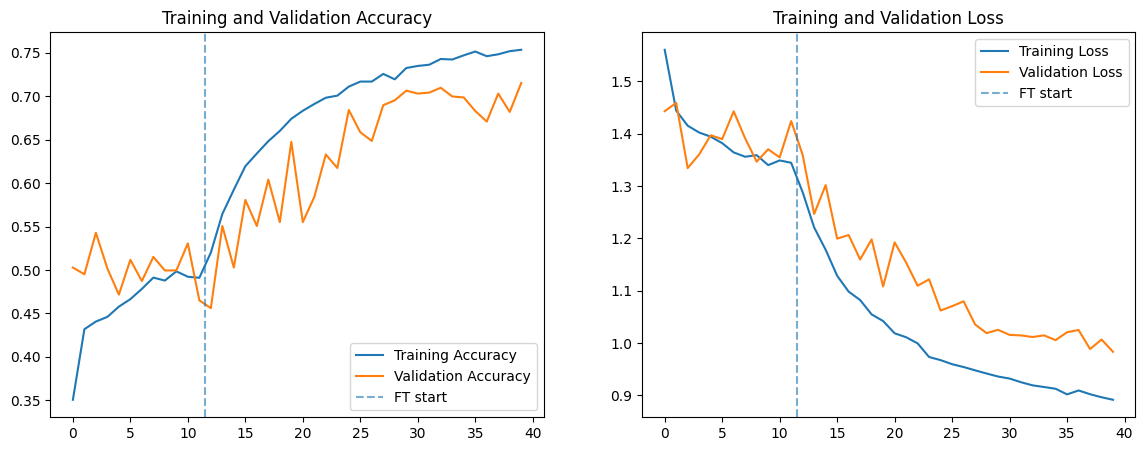

In [11]:
import matplotlib.pyplot as plt

def merge_histories(h1, h2):
    """Concatenate Keras History objects epoch-wise."""
    keys = set(h1.history.keys()) | set(h2.history.keys())
    merged = {k: list(h1.history.get(k, [])) + list(h2.history.get(k, [])) for k in keys}
    class _H: pass
    H = _H()
    H.history = merged
    return H


def plot_training_history(history, ft_start_epoch=None):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if ft_start_epoch is not None and len(acc) >= ft_start_epoch:
        plt.axvline(x=ft_start_epoch - 0.5, linestyle='--', alpha=0.6, label='FT start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if ft_start_epoch is not None and len(loss) >= ft_start_epoch:
        plt.axvline(x=ft_start_epoch - 0.5, linestyle='--', alpha=0.6, label='FT start')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

merged_history = merge_histories(history_head, history_ft)
plot_training_history(merged_history, ft_start_epoch=EPOCHS_HEAD)


29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step
Test Accuracy: 0.7029
Macro F1:      0.6809

Classification Report:
              precision    recall  f1-score   support

          H1     0.7367    0.8902    0.8062       437
          H2     0.4966    0.3133    0.3842       233
          H3     0.7347    0.4390    0.5496        82
          H5     0.9221    0.8875    0.9045        80
          H6     0.6436    0.9286    0.7602        70

    accuracy                         0.7029       902
   macro avg     0.7067    0.6917    0.6809       902
weighted avg     0.6837    0.7029    0.6790       902



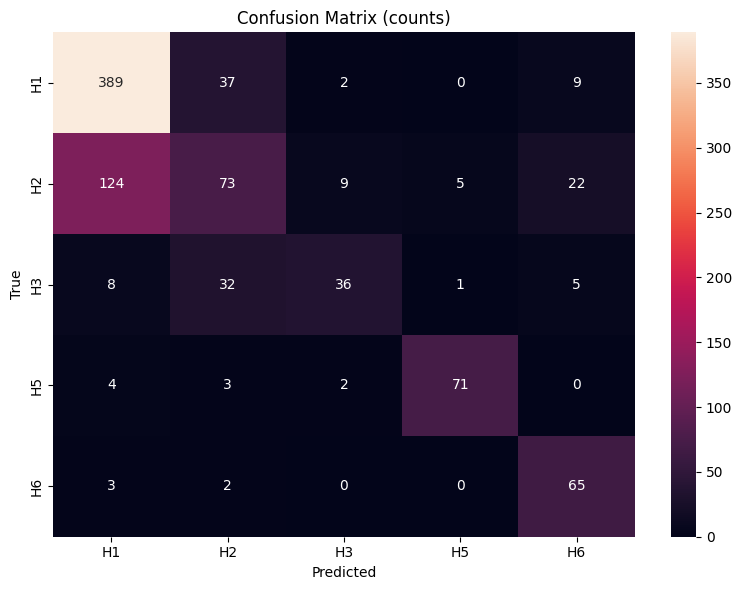

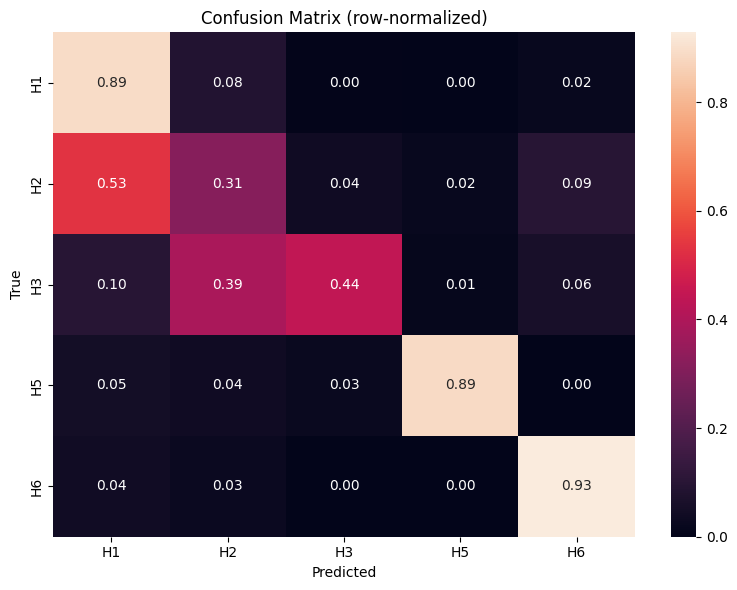

Misclassified: 268/902
✗ H1\H1_109a_24.jpg.jpg | true=H1  pred=H2
✗ H1\H1_111a_11.jpg.jpg | true=H1  pred=H2
✗ H1\H1_113b_8.jpg.jpg | true=H1  pred=H2
✗ H1\H1_113c_6.jpg.jpg | true=H1  pred=H2
✗ H1\H1_115c_4.jpg.jpg | true=H1  pred=H2
✗ H1\H1_115c_7.jpg.jpg | true=H1  pred=H2
✗ H1\H1_12c_1.jpg.jpg | true=H1  pred=H2
✗ H1\H1_12c_2.jpg.jpg | true=H1  pred=H2
✗ H1\H1_12c_9.jpg.jpg | true=H1  pred=H2
✗ H1\H1_12d_3.jpg.jpg | true=H1  pred=H2
✗ H1\H1_13b_10.jpg.jpg | true=H1  pred=H2
✗ H1\H1_13b_2.jpg.jpg | true=H1  pred=H2


In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

test_generator.reset()

steps = math.ceil(test_generator.samples / test_generator.batch_size)

Y_pred = model.predict(test_generator, steps=steps, verbose=1)

y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes

assert len(y_true) == len(y_pred) == test_generator.samples, \
    f"Lengths mismatch: y_true={len(y_true)} y_pred={len(y_pred)} samples={test_generator.samples}"

idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}\n")

print('Classification Report:')
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4, zero_division=0
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.tight_layout()
plt.show()

cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (row-normalized)')
plt.tight_layout()
plt.show()

filenames = np.array(test_generator.filenames)
wrong_idx = np.where(y_pred != y_true)[0]
print(f"Misclassified: {len(wrong_idx)}/{len(y_true)}")
for i in wrong_idx[:12]:
    print(f"✗ {filenames[i]} | true={class_names[y_true[i]]}  pred={class_names[y_pred[i]]}")


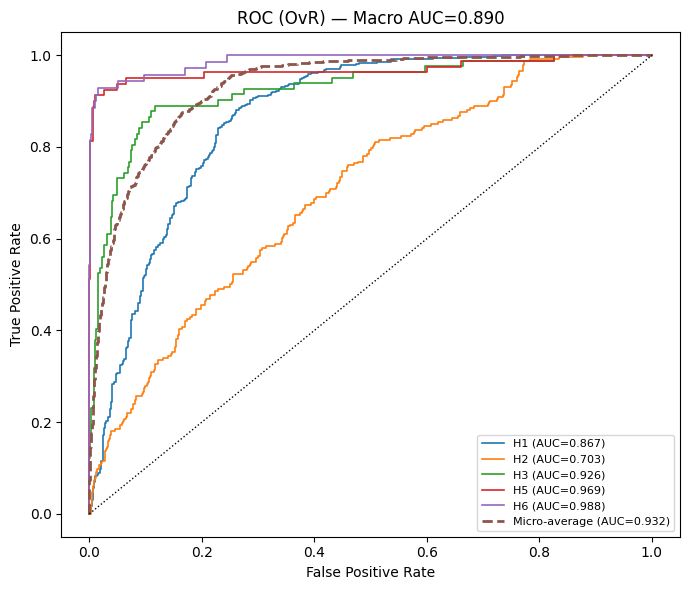

In [18]:
# ==== Cell 10: ROC curves & AUC (OvR) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

C = len(class_names)
y_true_oh = label_binarize(y_true, classes=list(range(C)))  # shape (N, C)

per_class_auc = []
plt.figure(figsize=(7, 6))
for i in range(C):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], Y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    per_class_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.2, label=f'{class_names[i]} (AUC={roc_auc:.3f})')

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_true_oh.ravel(), Y_pred.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, lw=2.0, linestyle='--', label=f'Micro-average (AUC={auc_micro:.3f})')

# Macro-average
auc_macro = np.mean(per_class_auc)
plt.plot([0,1],[0,1], 'k:', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC (OvR) — Macro AUC={auc_macro:.3f}')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()
